
# BDI

## LSTM

In [1]:
#to install tensorflow: open anaconda prompt > conda create -n tf tensorflow > conda activate tf
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN
from statsmodels.tsa.stattools import adfuller

In [2]:
df= pd.read_csv('Baltic Dry Index Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df.head()

,BDI
Date,
2012-07-04,1103.0
2012-07-05,1138.0
2012-07-06,1157.0
2012-07-07,1159.5
2012-07-08,1159.5


In [3]:
df_diff=df.diff().dropna()

In [4]:
result=adfuller(df_diff)
print('statistiques ADf:{}'.format(result[0]))
print('p-value:{}'.format(result[1]))
print('valeurs critiques:')
for key, value in result[4].items():
    print('\t {} : {}'.format(key,value))

statistiques ADf:-12.145396822282459
p-value:1.6151369416805567e-22
valeurs critiques:
	 1% : -3.4321892422972575
	 5% : -2.8623526737372837
	 10% : -2.5672025996313876


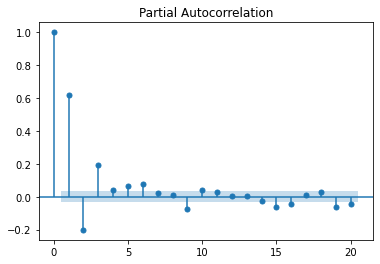

In [5]:
plot_pacf(df_diff,lags=20)
plt.show()

In [6]:
train=df_diff[:-30].values

In [7]:
train

array([[ 35. ],
       [ 19. ],
       [  2.5],
       ...,
       [-67. ],
       [-48. ],
       [-11. ]])

In [8]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+1, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
time_step = 3
X_train, y_train = create_dataset(train, time_step)
#X_test, ytest = create_dataset(test_data, time_step)

In [10]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
#X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [11]:
def creat_model():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [12]:
model_1j=creat_model()
model_1j.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [13]:
hist_1j=model_1j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)
# converganece de l'erreur est àpres ~1750 epochs avec une valeur de ~175, mais les résultats sont mieux avec 100 épochs seulement

Epoch 1/100
56/56 [==============================] - 9s 12ms/step - loss: 1185.8253
Epoch 2/100
56/56 [==============================] - 1s 12ms/step - loss: 1092.2222
Epoch 3/100
56/56 [==============================] - 1s 12ms/step - loss: 1028.8251
Epoch 4/100
56/56 [==============================] - 1s 12ms/step - loss: 979.6682
Epoch 5/100
56/56 [==============================] - 1s 12ms/step - loss: 940.8057
Epoch 6/100
56/56 [==============================] - 1s 12ms/step - loss: 910.9819
Epoch 7/100
56/56 [==============================] - 1s 12ms/step - loss: 885.3480
Epoch 8/100
56/56 [==============================] - 1s 12ms/step - loss: 864.4129
Epoch 9/100
56/56 [==============================] - 1s 12ms/step - loss: 845.9641
Epoch 10/100
56/56 [==============================] - 1s 12ms/step - loss: 831.3324
Epoch 11/100
56/56 [==============================] - 1s 12ms/step - loss: 816.5838
Epoch 12/100
56/56 [==============================] - 1s 12ms/step - loss: 805.345

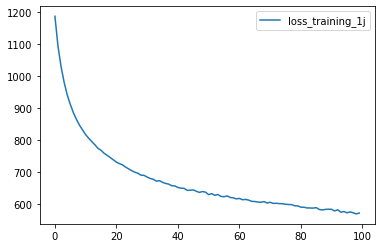

In [14]:
plt.plot(hist_1j.history['loss'],label='loss_training_1j')
plt.legend()

In [15]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    prediction=model_1j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,1)) 
    x, x_diff = df['BDI'].iloc[p-1], prediction.reshape(1,)
    
    if p==-1:
        test_df=df[-1:]
    else:
        test_df=df[p:p+1]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test_df.index)
    values.append(serie[-1:].values.reshape((1,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=1
rmses=rmses/30
maes=maes/30


1/1 [==============================] - 0s 31ms/step


In [16]:
values

[array([2357.10522461]),
 array([2355.93774414]),
 array([2312.56323242]),
 array([2319.39233398]),
 array([2213.02050781]),
 array([2123.76513672]),
 array([2096.77685547]),
 array([2034.45666504]),
 array([2054.46948242]),
 array([2040.67175293]),
 array([2038.56005859]),
 array([2003.4375]),
 array([2038.41357422]),
 array([2088.01782227]),
 array([2207.56860352]),
 array([2095.90087891]),
 array([2116.79956055]),
 array([2117.89404297]),
 array([2124.80395508]),
 array([2097.11743164]),
 array([2180.38256836]),
 array([2276.83666992]),
 array([2321.14331055]),
 array([2337.20947266]),
 array([2354.19628906]),
 array([2402.7590332]),
 array([2437.98828125]),
 array([2433.24780273]),
 array([2393.74438477]),
 array([2394.7890625])]

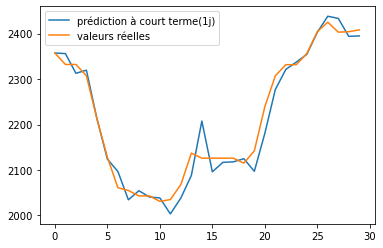

In [17]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df[-30:].values,label='valeurs réelles')
plt.legend()

In [18]:
maes,rmses

(20.206380208333332, 20.206380208333332)

In [48]:
!mkdir  saved_models
model_1j.save('saved_models/model_1j.h5')

### prédiction à long terme: 30 jours

In [21]:
train=df_diff[:-300].values

In [22]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset_mois(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-30):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+30, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
time_step = 3
X_train, y_train = create_dataset_mois(train, time_step)

In [24]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [25]:
def creat_model_mois():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(3,1)))
    model.add(LSTM(50))
    model.add(Dense(30))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [26]:
model_30j=creat_model_mois()
model_30j.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
Total params: 32,130
Trainable params: 32,130
Non-trainable params: 0
_________________________________________________________________


In [27]:
hist_30j=model_30j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
51/51 [==============================] - 9s 12ms/step - loss: 771.8304
Epoch 2/100
51/51 [==============================] - 1s 12ms/step - loss: 766.7499
Epoch 3/100
51/51 [==============================] - 1s 12ms/step - loss: 762.3263
Epoch 4/100
51/51 [==============================] - 1s 12ms/step - loss: 759.8342
Epoch 5/100
51/51 [==============================] - 1s 12ms/step - loss: 758.3331
Epoch 6/100
51/51 [==============================] - 1s 12ms/step - loss: 757.1429
Epoch 7/100
51/51 [==============================] - 1s 13ms/step - loss: 756.3171
Epoch 8/100
51/51 [==============================] - 1s 12ms/step - loss: 755.4956
Epoch 9/100
51/51 [==============================] - 1s 12ms/step - loss: 754.6796
Epoch 10/100
51/51 [==============================] - 1s 12ms/step - loss: 753.7512
Epoch 11/100
51/51 [==============================] - 1s 13ms/step - loss: 752.9897
Epoch 12/100
51/51 [==============================] - 1s 12ms/step - loss: 752.1118
E

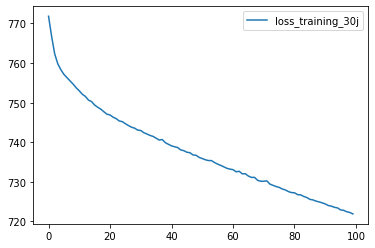

In [28]:
plt.plot(hist_30j.history['loss'],label='loss_training_30j')
plt.legend()

In [29]:
p=-300
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_30j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,1)) 
    x, x_diff = df['BDI'].iloc[p-1], prediction.reshape(30,)
    
    if p==-30:
        test_df=df[-30:]
    else:
        test_df=df[p:p+30]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test_df.index)
    values.append(serie[-30:].values.reshape((30,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=30
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 23ms/step


In [30]:
values

[array([3235.92797852, 3217.51220703, 3196.68139648, 3174.50927734,
        3153.29150391, 3136.62304688, 3124.10424805, 3113.65429688,
        3102.90917969, 3090.73901367, 3077.3828125 , 3067.92700195,
        3059.60913086, 3050.2097168 , 3042.52612305, 3034.84082031,
        3022.62646484, 3012.72265625, 3008.65112305, 3006.72070312,
        3004.48974609, 3001.23168945, 2996.52856445, 2992.61621094,
        2990.59765625, 2991.12695312, 2992.98339844, 2995.00805664,
        2998.20117188, 3000.04931641]),
 array([3282.27416992, 3278.38452148, 3274.55126953, 3274.06005859,
        3275.84399414, 3279.54125977, 3282.40161133, 3284.54492188,
        3285.6171875 , 3287.40112305, 3288.67871094, 3289.45239258,
        3289.84838867, 3290.61694336, 3291.22094727, 3292.38085938,
        3293.80883789, 3295.78222656, 3297.17285156, 3298.78076172,
        3299.78515625, 3301.58813477, 3304.3449707 , 3308.01806641,
        3311.17382812, 3311.16186523, 3310.49047852, 3309.99414062,
        

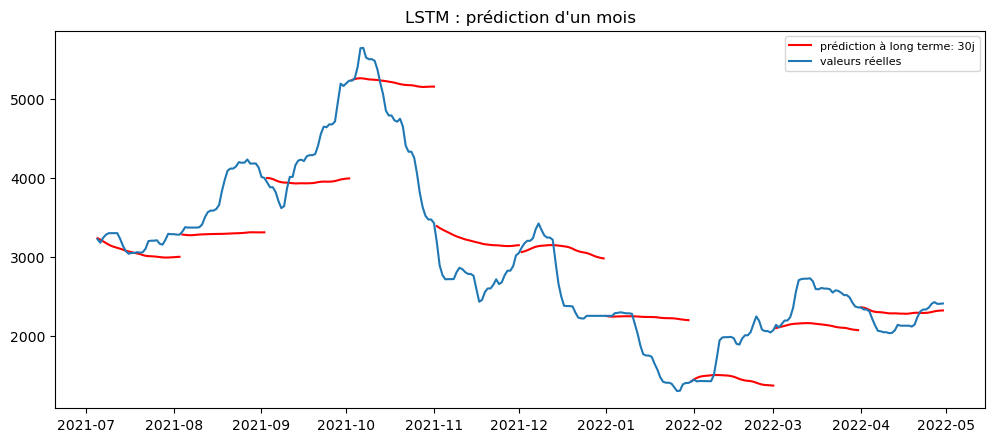

In [31]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction à long terme: 30j')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df[-300:].BDI, label='valeurs réelles')

plt.title("LSTM : prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

In [32]:
maes,rmses

(407.8576790364583, 491.34487942035014)

In [49]:
model_30j.save('saved_models/model_30j.h5')

### prediction d'une semaine

In [33]:
train=df_diff[:-70].values


In [34]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset_semaine(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-7):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step:i + time_step+7, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
time_step = 3
X_train, y_train = create_dataset_semaine(train, time_step)

In [36]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [37]:
def creat_model_semaine():
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(3,1)))
    model.add(LSTM(50))
    model.add(Dense(7))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return(model)

In [38]:
model_7j=creat_model_semaine()
model_7j.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 50)             10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 7)                 357       
                                                                 
Total params: 30,957
Trainable params: 30,957
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist_7j=model_7j.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
55/55 [==============================] - 9s 12ms/step - loss: 1196.0448
Epoch 2/100
55/55 [==============================] - 1s 12ms/step - loss: 1167.5045
Epoch 3/100
55/55 [==============================] - 1s 12ms/step - loss: 1143.4951
Epoch 4/100
55/55 [==============================] - 1s 12ms/step - loss: 1130.1864
Epoch 5/100
55/55 [==============================] - 1s 12ms/step - loss: 1122.8649
Epoch 6/100
55/55 [==============================] - 1s 12ms/step - loss: 1117.4594
Epoch 7/100
55/55 [==============================] - 1s 14ms/step - loss: 1111.5278
Epoch 8/100
55/55 [==============================] - 1s 12ms/step - loss: 1106.7291
Epoch 9/100
55/55 [==============================] - 1s 13ms/step - loss: 1102.2211
Epoch 10/100
55/55 [==============================] - 1s 12ms/step - loss: 1098.2202
Epoch 11/100
55/55 [==============================] - 1s 12ms/step - loss: 1094.8689
Epoch 12/100
55/55 [==============================] - 1s 13ms/step - loss:

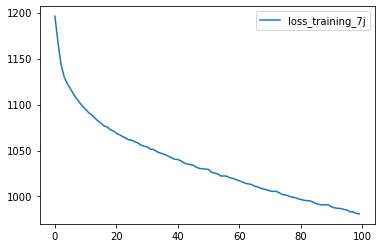

In [40]:
plt.plot(hist_7j.history['loss'],label='loss_training_7j')
plt.legend()

In [41]:
p=-70
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(10):
    prediction=model_7j.predict(df_diff[p-time_step:p].values.reshape(1,time_step,1)) 
    x, x_diff = df['BDI'].iloc[p-1], prediction.reshape(7,)
    
    if p==-7:
        test_df=df[-7:]
    else:
        test_df=df[p:p+7]
    serie = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test_df.index)
    values.append(serie[-7:].values.reshape((7,)))
    mae = np.mean(np.abs(test_df.values - serie.values))
    maes=maes+mae
    rmse = np.mean((test_df.values - serie.values)**2)**.5
    rmses=rmses+rmse
    _list_rmses.append(rmse)
    _list_maes.append(mae)
    prédictions.append(serie)
    p+=7
rmses=rmses/10
maes=maes/10


1/1 [==============================] - 0s 38ms/step


In [42]:
values

[array([2012.83886719, 2029.28076172, 2053.0168457 , 2077.25195312,
        2097.47070312, 2109.03442383, 2113.66015625]),
 array([2039.92431641, 2019.77941895, 1993.16784668, 1961.36608887,
        1932.18652344, 1910.4987793 , 1897.45446777]),
 array([2196.36206055, 2210.98974609, 2227.94873047, 2238.1394043 ,
        2241.32177734, 2236.47949219, 2229.51220703]),
 array([2721.55517578, 2731.02587891, 2741.28442383, 2749.31762695,
        2753.76074219, 2752.64233398, 2749.13256836]),
 array([2578.98828125, 2567.51611328, 2564.3581543 , 2570.29858398,
        2579.46826172, 2585.57592773, 2588.50610352]),
 array([2493.99633789, 2487.10400391, 2483.28637695, 2477.58569336,
        2470.55737305, 2464.171875  , 2458.79541016]),
 array([2305.0324707 , 2287.29589844, 2277.65161133, 2272.69042969,
        2270.72509766, 2269.10327148, 2267.0402832 ]),
 array([2043.52587891, 2033.48376465, 2018.23803711, 2004.88195801,
        1997.70361328, 1996.765625  , 1998.42016602]),
 array([2144.335

In [43]:
rmses,maes

(117.74097311549365, 95.84774344308036)

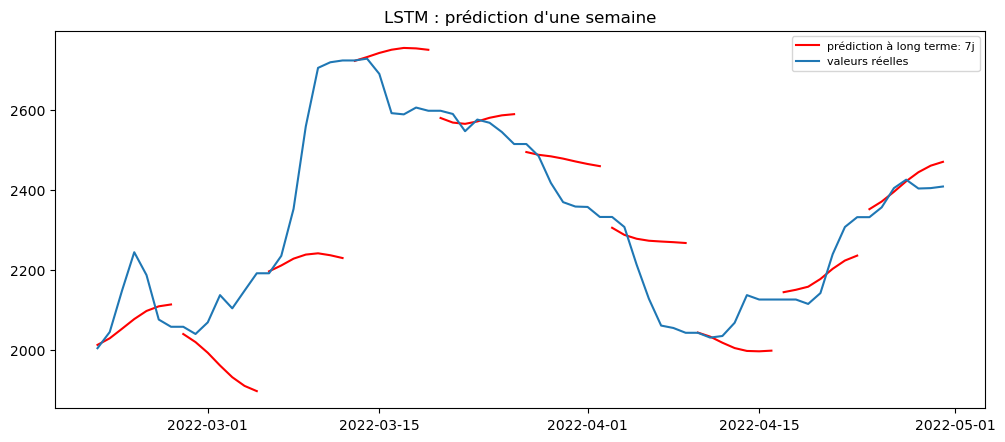

In [44]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(prédictions)):
    if i==0:
        plt.plot(prédictions[i],color='r',label='prédiction à long terme: 7j')
    else:
        plt.plot(prédictions[i],color='r')
plt.plot(df[-70:].BDI, label='valeurs réelles')

plt.title("LSTM : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

In [50]:
model_7j.save('saved_models/model_7j.h5')